In [226]:
import numpy as np
import os
from copy import copy

from matplotlib import pyplot as plt
%matplotlib inline
from scipy.io import loadmat

import cvxpy as cvx

In [2]:
# load the data

servercsi = loadmat(os.path.join(os.path.abspath('..'),'data','servercsi.mat'))['servercsi']
clientcsi = loadmat(os.path.join(os.path.abspath('..'),'data','clientcsi.mat'))['clientcsi']

In [3]:
print(servercsi.shape)

(5208, 9)


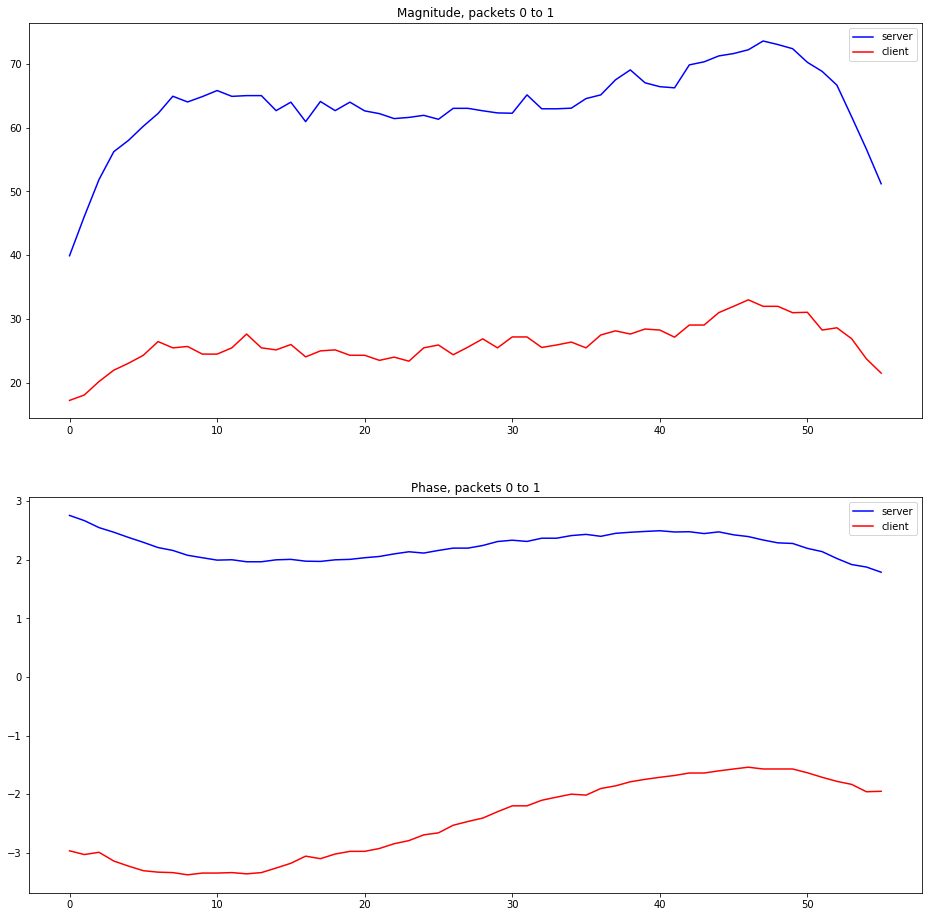

In [4]:
index = 0
n_packets=1
start = 0
fig, ax = plt.subplots(2,1, figsize=(16,16))
_ = ax[0].plot(np.abs(servercsi[56*start:56*start +n_packets*56,index]), label='server', c='b')
_ = ax[0].plot(np.abs(clientcsi[56*start:56*start +n_packets*56,index]), label='client', c='r')
for i in range(n_packets-1):
    _ = ax[0].axvline(56*(i+1), linestyle='-.', c='k')
_ = ax[0].set_title('Magnitude, packets %d to %d' % (start, start+n_packets))
_ = ax[0].legend()

_ = ax[1].plot(np.unwrap(np.angle(servercsi[56*start:56*start +n_packets*56,index])), label='server', c='b')
_ = ax[1].plot(np.unwrap(np.angle(clientcsi[56*start:56*start +n_packets*56,index])), label='client', c='r')
for i in range(n_packets-1):
    _ = ax[1].axvline(56*(i+1), linestyle='-.', c='k')
_ = ax[1].set_title('Phase, packets %d to %d' % (start, start+n_packets))

_ = ax[1].legend()

In [5]:
# set up the parameters
f_center = 5180 #MHz
temp = np.linspace(-1,1,65)
#temp = temp[1:-1]

f_all = 10*temp + 5180

mask = np.ones(f_all.shape, bool)
mask[32] = 0
mask[-4:] = 0
mask[:4] = 0
f = f_all[mask]


In [6]:
print(f.shape)
print(f)
print(f[-1]-f[0])

(56,)
[5171.25   5171.5625 5171.875  5172.1875 5172.5    5172.8125 5173.125
 5173.4375 5173.75   5174.0625 5174.375  5174.6875 5175.     5175.3125
 5175.625  5175.9375 5176.25   5176.5625 5176.875  5177.1875 5177.5
 5177.8125 5178.125  5178.4375 5178.75   5179.0625 5179.375  5179.6875
 5180.3125 5180.625  5180.9375 5181.25   5181.5625 5181.875  5182.1875
 5182.5    5182.8125 5183.125  5183.4375 5183.75   5184.0625 5184.375
 5184.6875 5185.     5185.3125 5185.625  5185.9375 5186.25   5186.5625
 5186.875  5187.1875 5187.5    5187.8125 5188.125  5188.4375 5188.75  ]
17.5


In [7]:
print(f_all)
print(f_all[-1]-f_all[0])

[5170.     5170.3125 5170.625  5170.9375 5171.25   5171.5625 5171.875
 5172.1875 5172.5    5172.8125 5173.125  5173.4375 5173.75   5174.0625
 5174.375  5174.6875 5175.     5175.3125 5175.625  5175.9375 5176.25
 5176.5625 5176.875  5177.1875 5177.5    5177.8125 5178.125  5178.4375
 5178.75   5179.0625 5179.375  5179.6875 5180.     5180.3125 5180.625
 5180.9375 5181.25   5181.5625 5181.875  5182.1875 5182.5    5182.8125
 5183.125  5183.4375 5183.75   5184.0625 5184.375  5184.6875 5185.
 5185.3125 5185.625  5185.9375 5186.25   5186.5625 5186.875  5187.1875
 5187.5    5187.8125 5188.125  5188.4375 5188.75   5189.0625 5189.375
 5189.6875 5190.    ]
20.0


In [8]:
def build_dict(f, t):
    """Build the dictionary for sparsely approximating the data
    
    """
    T = np.array(f).astype(float).reshape((-1,1))@t.reshape((1,-1))
    T = np.exp(-1j*2*np.pi*T)
    return T

In [9]:
def solve_l1_reg(A, b, gammas):
    """Solve regularized problem (LASSO)
    
    """
    x = cvx.Variable(A.shape[1], complex=True)
    gamma = cvx.Parameter(nonneg=True)
    fit = cvx.norm(A@x-b, 2)
    reg = cvx.norm(x, 1) 
    obj = cvx.Minimize(reg + gamma*fit)
    problem = cvx.Problem(obj)
    fits = []
    regs = []
    xs = []
    for g in gammas:
        gamma.value = g
        problem.solve()
        regs.append(reg.value)
        fits.append(fit.value)
        xs.append(x.value)
    
    return xs, fits, regs

In [23]:
def find_max_peak(t, x):
    x_abs = np.abs(x)
    idx = np.argmax(x_abs)
    return idx, t[idx]

In [11]:
def find_first_peak(t, x, thres):
    x_abs = np.abs(x)
    gt = x_abs > thres
    idx = next(i for i,v in enumerate(gt) if v==1)
    return idx, t[idx]

In [195]:
def solve_coarse_fine(b, f, coarse_range=(0,4), N_coarse = 300, fine_range=(-.1,.1), N_fine = 500, gamma=10.):
    t_coarse = np.linspace(coarse_range[0], coarse_range[1], N_coarse)
    A = build_dict(f, t_coarse)
    x, fit, reg = solve_l1_reg(A, b, [gamma])
    idx, tc = find_max_peak(t_coarse, x)
    t_fine = tc + np.linspace(fine_range[0], fine_range[1], N_fine)
    A = build_dict(f, t_fine)
    x, fit, reg = solve_l1_reg(A, b, [gamma])
    return x[0], t_fine, A, fit, reg

In [18]:
def post_process(x, A, t, L):
    idx, t_max = find_max_peak(t, x)
    x_n = x/np.abs(x[idx])
    idx, t_idx = find_first_peak(t, x_n, .3)
    

In [199]:
# solve with cvx
packet_index = 83
antenna_index = 0
t_min = 0.5
t_max = 5 # timescale is microseconds, should be compliant with MHz

bs = servercsi[packet_index*56:(packet_index+1)*56,antenna_index] # server data
bc = clientcsi[packet_index*56:(packet_index+1)*56,antenna_index] # client data

bs = bs-np.mean(bs)
bc = bc-np.mean(bc)
# algorithm parameters
N_fine = 200
gamma=1.
server = {}
xs, t, A, fits, regs = solve_coarse_fine(bs, f, coarse_range=(0,1), N_fine=N_fine, gamma=gamma)
server['fit'] = fits
server['reg'] = regs
server['xs'] = xs
server['t'] = t
server['A'] = A

client = {}
xs, t, A, fits, regs = solve_coarse_fine(bc, f, coarse_range=(0,1), N_fine=N_fine, gamma=gamma)
client['fit'] = fits
client['reg'] = regs
client['xs'] = xs
client['t'] = t
client['A'] = A



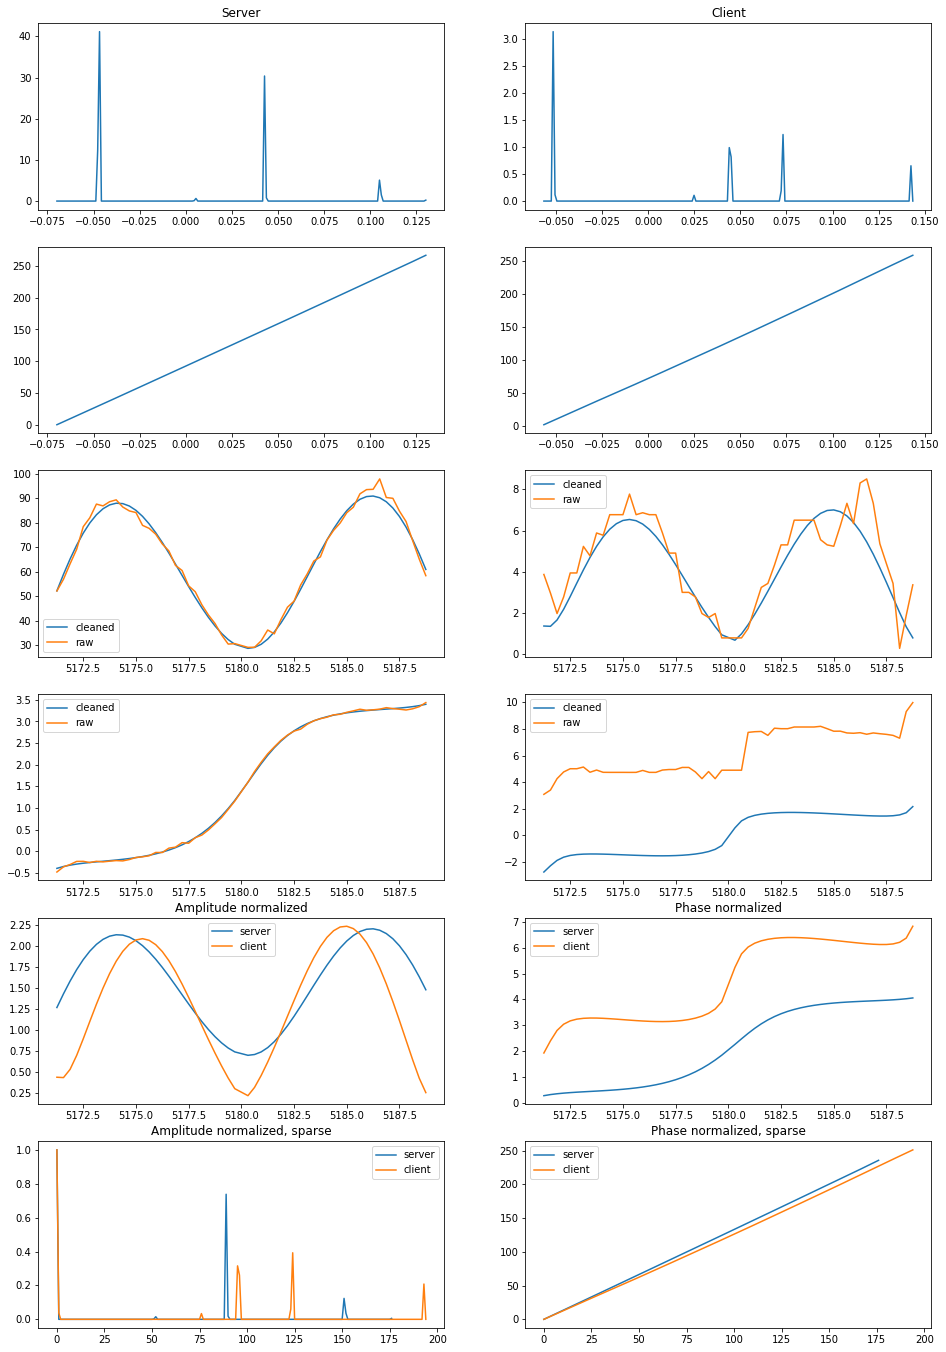

In [200]:
server['h'] = server['A']@server['xs']
client['h'] = client['A']@client['xs']

idx = np.argmax(np.abs(server['xs']))
server['idx'] = idx
server['xn'] = server['xs']/server['xs'][idx]

idx = np.argmax(np.abs(client['xs']))
client['idx'] = idx
client['xn'] = client['xs']/client['xs'][idx]

server['hn'] = server['A']@server['xn']
client['hn'] = client['A']@client['xn']




# plot results
fig, ax = plt.subplots(6,2, figsize=(16,24))
_ = ax[0][0].plot(server['t'], np.abs(server['xs']))
_ = ax[0][0].set_title('Server')
_ = ax[0][1].plot(client['t'], np.abs(client['xs']))
_ = ax[0][1].set_title('Client')

_ = ax[1][0].plot(server['t'], np.unwrap(np.angle(server['xs'])))
_ = ax[1][1].plot(client['t'], np.unwrap(np.angle(client['xs'])))

_ = ax[2][0].plot(f, np.abs(server['h']), label='cleaned')
_ = ax[2][0].plot(f, np.abs(bs), label='raw')
_ = ax[2][0].legend()
_ = ax[2][1].plot(f, np.abs(client['h']), label='cleaned')
_ = ax[2][1].plot(f, np.abs(bc), label='raw')
_ = ax[2][1].legend()

_ = ax[3][0].plot(f, np.unwrap(np.angle(server['h'])), label='cleaned')
_ = ax[3][0].plot(f, np.unwrap(np.angle(bs)), label='raw')
_ = ax[3][0].legend()
_ = ax[3][1].plot(f, np.unwrap(np.angle(client['h'])), label='cleaned')
_ = ax[3][1].plot(f, np.unwrap(np.angle(bc)), label='raw')
_ = ax[3][1].legend()

_ = ax[4][0].plot(f, np.abs(server['hn']), label='server')
_ = ax[4][0].plot(f, np.abs(client['hn']), label='client')
_ = ax[4][0].set_title('Amplitude normalized')
_ = ax[4][0].legend()

_ = ax[4][1].plot(f, np.unwrap(np.angle(server['hn'])), label='server')
_ = ax[4][1].plot(f, np.unwrap(np.angle(client['hn'])), label='client')
_ = ax[4][1].set_title('Phase normalized')
_ = ax[4][1].legend()

_ = ax[5][0].plot(np.abs(server['xn'][server['idx']:]), label='server')
_ = ax[5][0].plot(np.abs(client['xn'][client['idx']:]), label='client')
_ = ax[5][0].set_title('Amplitude normalized, sparse')
_ = ax[5][0].legend()

_ = ax[5][1].plot(np.unwrap(np.angle(server['xn'][server['idx']:])), label='server')
_ = ax[5][1].plot(np.unwrap(np.angle(client['xn'][client['idx']:])), label='client')
_ = ax[5][1].set_title('Phase normalized, sparse')
_ = ax[5][1].legend()


In [125]:
c_raw_p = np.corrcoef(np.angle(bs), np.angle(bc))[1,0]
c_pro_p = np.corrcoef(np.angle(server['xn'][server['idx']:server['idx']+100]), 
                    np.angle(client['xn'][client['idx']:client['idx']+100]))[1,0]

c_raw_m = np.corrcoef(np.abs(bs), np.abs(bc))[1,0]
c_pro_m = np.corrcoef(np.abs(server['xn'][server['idx']:server['idx']+100]), 
                    np.abs(client['xn'][client['idx']:client['idx']+100]))[1,0]

print(c_raw_p, c_pro_p)
print(c_raw_m, c_pro_m)

0.8888569098525482 0.8874466471126058
0.8747408303121533 0.7152610782974516


In [247]:
p_idx = 42
a_idx = 0
gammas = np.logspace(0,3,100)
t = np.linspace(0,.1,200)
A = build_dict(f, t)
b = servercsi[p_idx*56:(p_idx+1)*56,a_idx]
b = b-np.mean(b)
xs, fits, regs = solve_l1_reg(A, b, gammas)
idxs = []
ts = []
for x in xs:
    idx, t_max = find_max_peak(t, x)
    idxs.append(idx)
    ts.append(t_max)

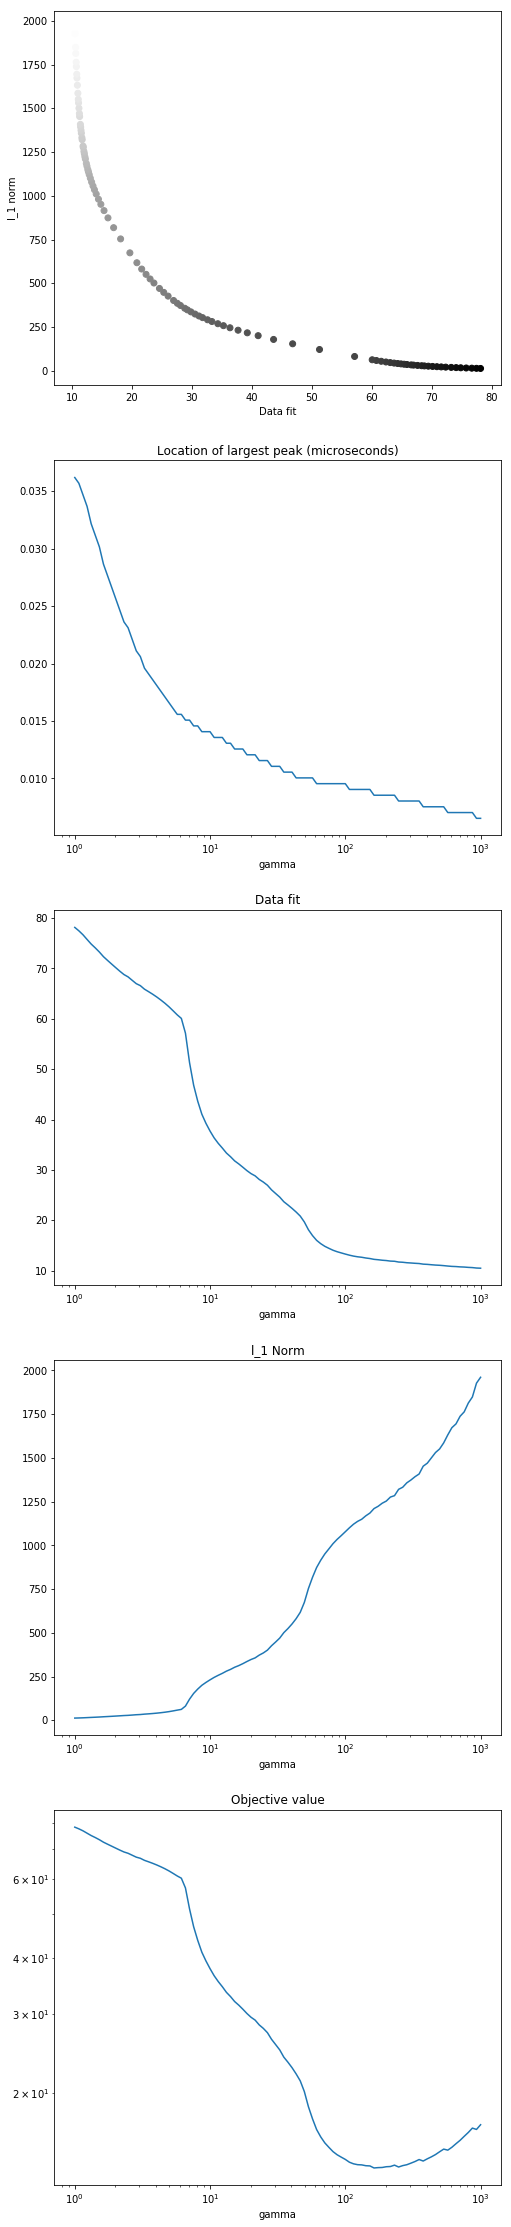

In [249]:
cs = np.linspace(0,1,len(gammas))
fig, ax = plt.subplots(5,1, figsize=(8,40))
_ = ax[0].scatter(fits, regs, c=cs, cmap='gray')
_ = ax[0].set_xlabel('Data fit')
_ = ax[0].set_ylabel('l_1 norm')


_ = ax[1].semilogx(gammas, ts)
_ = ax[1].set_title('Location of largest peak (microseconds)')
_ = ax[1].set_xlabel('gamma')
_ = ax[2].semilogx(gammas, fits)
_ = ax[2].set_title('Data fit')
_ = ax[2].set_xlabel('gamma')
_ = ax[3].semilogx(gammas, regs)
_ = ax[3].set_title('l_1 Norm')
_ = ax[3].set_xlabel('gamma')
_ = ax[4].loglog(gammas, [f+g*t for (f,g,t) in zip(fits, gammas, ts)])
_ = ax[4].set_title('Objective value')
_ = ax[4].set_xlabel('gamma')


Correlations:
raw: 	 magnitude : 0.212 	 phase : 0.757
cleaned: 	 magnitude : 0.236 	 phase : -0.835


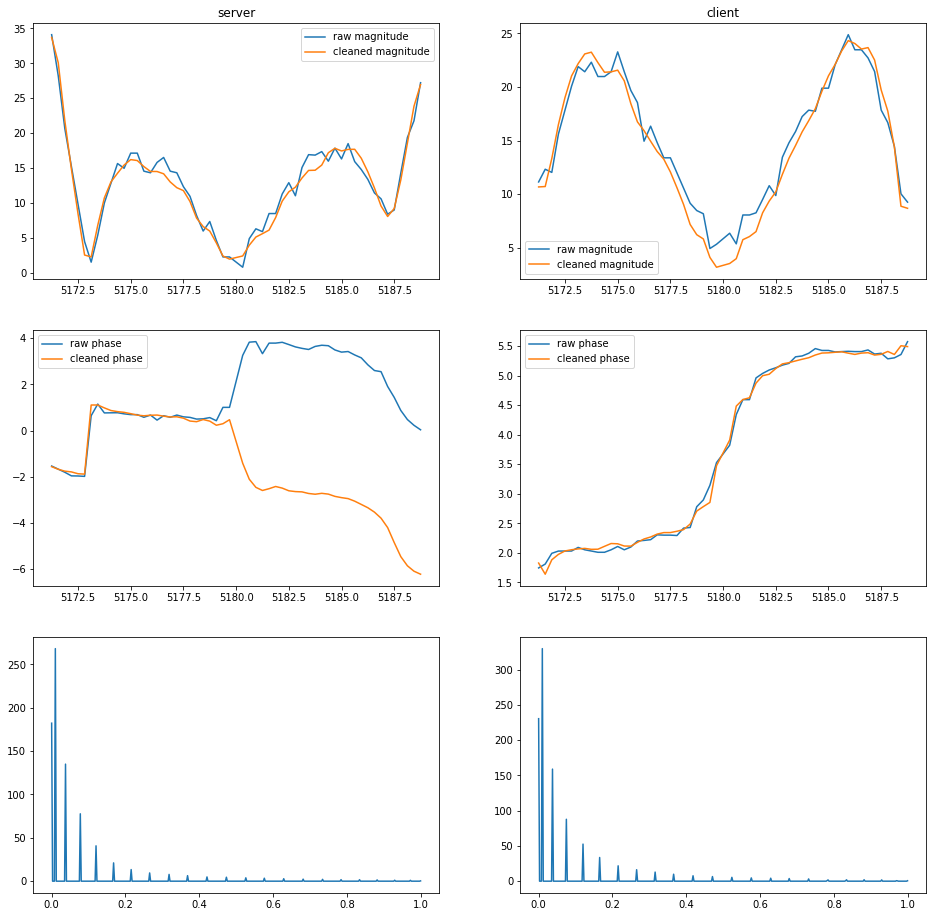

In [250]:
p_idx=0
a_idx=0
t = np.linspace(0.0,1,400)
A = build_dict(f, t)
b = clientcsi[p_idx*56:(p_idx+1)*56,a_idx]
b = b-np.mean(b)
gammas = [120]
xs, fits, regs = solve_l1_reg(A, b, gammas)
x = copy(xs[0])
b_cleaned = A@x

b1 = servercsi[p_idx*56:(p_idx+1)*56,a_idx]
b1 = b1-np.mean(b1)

xs, fits, regs = solve_l1_reg(A, b1, gammas)
x1 = xs[0]
b1_cleaned = A@x1

fig, ax = plt.subplots(3,2, figsize=(16,16))

_ = ax[0][0].plot(f, np.abs(b1), label='raw magnitude')
_ = ax[0][0].plot(f, np.abs(b1_cleaned), label='cleaned magnitude')
_ = ax[0][0].legend()
_ = ax[0][0].set_title('server')
_ = ax[1][0].plot(f, np.unwrap(np.angle(b1)), label='raw phase')
_ = ax[1][0].plot(f, np.unwrap(np.angle(b1_cleaned)), label='cleaned phase')
_ = ax[1][0].legend()

_ = ax[0][1].plot(f, np.abs(b), label='raw magnitude')
_ = ax[0][1].plot(f, np.abs(b_cleaned), label='cleaned magnitude')
_ = ax[0][1].legend()
_ = ax[0][1].set_title('client')
_ = ax[1][1].plot(f, np.unwrap(np.angle(b)), label='raw phase')
_ = ax[1][1].plot(f, np.unwrap(np.angle(b_cleaned)), label='cleaned phase')
_ = ax[1][1].legend()

_ = ax[2][0].plot(t,np.abs(x1))
_ = ax[2][1].plot(t,np.abs(x))



c_r_m = np.corrcoef(np.abs(b1),np.abs(b))[1,0]
c_r_p = np.corrcoef(np.unwrap(np.angle(b1)), np.unwrap(np.angle(b)))[1,0]

c_c_m = np.corrcoef(np.abs(b1_cleaned),np.abs(b_cleaned))[1,0]
c_c_p = np.corrcoef(np.unwrap(np.angle(b1_cleaned)), np.unwrap(np.angle(b_cleaned)))[1,0]
print('Correlations:')
print('raw: \t magnitude : %.3f \t phase : %.3f' % (c_r_m, c_r_p))
print('cleaned: \t magnitude : %.3f \t phase : %.3f' % (c_c_m, c_c_p))